# Written by Abiola Obembe
## Date 17th March 2020
## Human cell record classification

#### In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

In [1]:
# install libraries
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline
print('Libraries installed!')

Libraries installed!


#### The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics

In [2]:
# Load dataset
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv


#!wget -O breast-cancer-wisconsin.data http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data            
#COLUMNS_COUNT = 11
#with open('breast-cancer-wisconsin.data', 'r') as File1:
#  cell_df = pd.read_csv('breast-cancer-wisconsin.data', skiprows=COLUMNS_COUNT, header=None, delimiter=',', skip_blank_lines=True)

    
#cell_df.columns = ['ID', 'Clump', 'UnifSize', 'UniShape','MargAdh','SingleSize','BareNuc ','BlandChrom','NormalNuc','Mit','Class']    

cell_df = pd.read_csv('cell_samples.csv')
cell_df.head(5)

--2020-03-17 19:17:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

100%[======================================>] 20,675      --.-K/s   in 0.002s  

2020-03-17 19:17:27 (10.1 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


#### The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

#### The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

#### Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

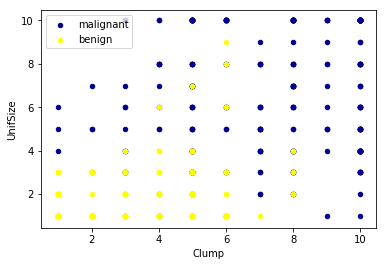

In [3]:
ax = cell_df[cell_df['Class']== 4].plot(kind = 'scatter', x = 'Clump', y ='UnifSize', color = 'DarkBlue', label = 'malignant')
cell_df[cell_df['Class']== 2].plot(kind = 'scatter', x = 'Clump', y ='UnifSize', color = 'Yellow', label = 'benign', ax = ax)

plt.show()

In [4]:
# Data pre-processing and selection
cell_df.shape

(699, 11)

In [5]:
cell_df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [6]:
cell_df.corr()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
ID,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.060051,-0.052072,-0.034901,-0.080226
Clump,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034,0.716001
UnifSize,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693,0.817904
UnifShape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911,0.818934
MargAdh,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633,0.696800
SingEpiSize,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101,0.682785
BlandChrom,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169,0.756616
NormNucl,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336,0.712244
Mit,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000,0.423170
Class,-0.080226,0.716001,0.817904,0.818934,0.696800,0.682785,0.756616,0.712244,0.423170,1.000000


In [7]:
cell_df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

In [8]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [9]:
cell_df[['BareNuc']].head(50)

,BareNuc
0,1
1,10
2,2
3,4
4,1
5,10
6,10
7,1
8,1
9,1


In [10]:
# convert object datatype to integer
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors ='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.head()


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [11]:
cell_df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

In [12]:
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [13]:
# Feature definition

X = np.asarray(cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']])
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [14]:
# define target field
cell_df[['Class']].dtypes
y = cell_df['Class'].values
y[0:5]

array([2, 2, 2, 2, 2])

In [20]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.19790469, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299,  0.75803177,  1.69516613,
         1.77286724, -0.18182716, -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.4242175 , -0.18182716, -0.61292736, -0.34839971],
       [ 0.55267873,  1.58320366,  1.6021918 , -0.63936553, -0.10545357,
         0.12505369, -0.18182716,  1.3540079 , -0.34839971],
       [-0.15686934, -0.70221201, -0.74177362,  0.05933312, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971]])

In [21]:
# Train_test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

print( "size of training set is : ", X_train.shape, y_train.shape)
print( "size of test set is : " , X_test. shape, y_test.shape)

size of training set is :  (546, 9) (546,)
size of test set is :  (137, 9) (137,)


In [22]:
# Modelling using rbf
from sklearn import svm
clf_rbf = svm.SVC(C=0.01, kernel='rbf', gamma='auto')
clf_rbf.fit(X_train, y_train)

# Prediction
yhat_rbf = clf_rbf.predict(X_test)

In [23]:
# Modelling using linear
from sklearn.svm import SVC
clf_lin = SVC(C=0.01, kernel='linear')
clf_lin.fit(X_train, y_train)

# Prediction
yhat_lin = clf_rbf.predict(X_test)

In [25]:
# Evaluation for rbf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_similarity_score

# Classification report
print(classification_report(y_test, yhat_rbf, labels=[2, 4]))

#  f1_score
print("The f1 score is: ", f1_score(y_test,yhat_rbf, average ='weighted'))

# jaccard score
print("The jaccard similarity score is: ", jaccard_similarity_score (y_test, yhat_rbf))


              precision    recall  f1-score   support

           2       0.95      0.99      0.97        79
           4       0.98      0.93      0.96        58

   micro avg       0.96      0.96      0.96       137
   macro avg       0.97      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137

The f1 score is:  0.9633592129161734
The jaccard similarity score is:  0.9635036496350365
